In [6]:
import glob
import os
import torch
import copy
from torch.autograd import Variable

import numpy as np
import pandas as pd
from PIL import Image

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision import transforms, models, datasets
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


#METADATA_SUBSET_PATH= "/dartfs-hpc/rc/home/t/f006cht/code/torch_test/dicom_metadata_df.csv"
METADATA_SUBSET_PATH = "/Users/franceskoback/Documents/research/pytorch_1/metadata_100subset_df.csv"


def get_manufacturer_labels(encoder, target_variable = "(0008, 0070) Manufacturer"):
    df = pd.read_csv(METADATA_SUBSET_PATH)
    df["id"] = df["id"].astype("str").str.zfill(8)
    df["code"] = encoder.fit_transform(df[target_variable])
    dictionary= {row["id"]: row["code"] for i, row in df.iterrows()}
    keys = dictionary.keys()
    values = dictionary.values()
    return dictionary

class CustomImageDataset(Dataset):
    def __init__(self):
        self.img_dir = "/Users/franceskoback/Documents/research/pytorch_1/xray_subsets"
        #self.img_dir = "/dartfs-hpc/rc/home/t/f006cht/scratch/OAI/processed_images/xrays/knee/BilatPAFixedFlex/224x224/no_dicom_proc/self_scaled/group_norm"
        self.images = glob.glob(os.path.join(self.img_dir, "*.npy"))
        self.le = preprocessing.LabelEncoder()
        self.label_map = get_manufacturer_labels(self.le)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.fromarray(np.load(img_path)).convert("RGB")
        image = transforms.ToTensor()(image)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        image=normalize(image)
        xray_id = os.path.basename(img_path).replace(".npy", "")
        label= self.label_map[xray_id]
        label= torch.as_tensor(label).long()       
        return (image, label)

def train_val_test_dataset(dataset, val_split=0.20):
    train_idx, rem_idx = train_test_split(list(range(len(dataset))), test_size=val_split)

    Test_size=0.5 # split equally between validataion and test sets 
    val_idx, test_idx  = train_test_split(list(rem_idx), test_size=Test_size)

    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    datasets['test'] = Subset(dataset, test_idx)
    return datasets

[[ 1.98403772  2.02336931  1.98232765 ...  1.99771827  1.97805248
   2.23712797]
 [ 1.97292227  1.93273564  1.8797235  ...  1.99942834  1.86946308
   2.16017485]
 [ 1.88399867  1.85407246  1.75574348 ...  1.89169398  1.80362542
   2.15846478]
 ...
 [ 0.88360817 -0.78456437 -0.68709042 ... -0.63749842 -0.63236821
  -0.63151317]
 [ 0.89985383 -0.78456437 -0.67854008 ... -0.63578835 -0.62894807
  -0.62894807]
 [ 0.89301355 -0.76575361 -0.67854008 ... -0.62894807 -0.6246729
  -0.62381786]]
torch.Size([3, 224, 224])


In [8]:
dataset = CustomImageDataset()
datasets = train_val_test_dataset(dataset)
print(len(datasets['train'].dataset)) #6
train_dataset= datasets['train']
val_dataset= datasets['val']
test_dataset= datasets['test']


train_loader = DataLoader(
    train_dataset, batch_size=10, shuffle=True
)
valid_loader = DataLoader(
    val_dataset, batch_size=10, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=10, shuffle=True
)

print(len(train_loader.dataset)) #6 
len_train=len(datasets['train'])
len_val= len(datasets['val'])
len_test= len(datasets['test'])

print("Training length", len(train_loader))
print("Validation length", len(valid_loader))
print("Testing length", len(test_loader))

100
80
Training length 8
Validation length 1
Testing length 1


In [9]:
def Net(num_classes):
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, num_classes)

    for params in model.parameters():
        params.requires_grad = True

    return model

params = {
    "model": "resnet18",
    #"device": "cuda",
    "lr": 0.001,
    "batch_size": 10, #64
    "num_workers": 1, #20
    "n_epochs": 50, #100
    "image_size": 224, 
    "in_channels": 2, #3
    "num_classes": 10, #12
    "device": "cpu"
}

model = Net(params['num_classes'])
model.eval().to(params["device"])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = params['lr'])

In [10]:
def train_one_epoch(epoch, model, loss_fn, optimizer, loader, device = "cpu"):
    #put model in training state
    model.train()
    train_loss=0.0
    epoch_loss=[]

    for batch_idx, (img,label) in enumerate(loader):  
        inputs = Variable(img.to(device).float(),requires_grad=True) # inputs and outputs 
        labels = Variable(label.to(device).float())
        
        optimizer.zero_grad() # sets all grads to None 

        # forward + backward + optimize
        outputs = model(inputs)
        pred = torch.argmax(outputs, dim=1)
        pred= Variable(pred.to(device).float(),requires_grad=True)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        if batch_idx % 200 == 0:
            loss, current = loss.item(), batch_idx * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(loader):>5d}]")
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))
    return model, train_loss


def test_one_epoch(epoch, model, loss_fn, loader, len_val, device = "cpu"):
    model.eval()

    running_loss = 0
    actual_labels = []
    pred_labels = []
    loss_values=[]
    
    for batch_idx, (img,label) in enumerate(loader):    
        inputs =img
        labels = label
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        
        log_preds = model(inputs)
        loss = loss_fn(log_preds, labels)

        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).cpu().numpy())
        actual_labels+= list(labels.cpu().numpy())

    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(pred_labels) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(pred_labels)
    
    
    return running_loss, accuracy, correct, total

## Training Loop

In [11]:
train_losses = []
valid_losses = []

for epoch in range(params['n_epochs']):
    model, train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]
    valid_loss, accuracy, correct, total = test_one_epoch(epoch, model, loss_fn, valid_loader, len_val)
    valid_losses+= [valid_loss]
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, 'checkpoint.tar')

loss: 225.858490  [    0/    8]
Epoch 1 avg Training loss: 127.968
Epoch 1 avg Valid loss: 2.488
Epoch 1 Valid accuracy: 0.0% (0 of 10 right)

loss: 121.454636  [    0/    8]
Epoch 2 avg Training loss: 125.956
Epoch 2 avg Valid loss: 2.943
Epoch 2 Valid accuracy: 0.0% (0 of 10 right)

loss: 152.024689  [    0/    8]
Epoch 3 avg Training loss: 128.338
Epoch 3 avg Valid loss: 2.932
Epoch 3 Valid accuracy: 0.0% (0 of 10 right)

loss: 67.197281  [    0/    8]
Epoch 4 avg Training loss: 135.882
Epoch 4 avg Valid loss: 2.960
Epoch 4 Valid accuracy: 0.0% (0 of 10 right)

loss: 149.963882  [    0/    8]
Epoch 5 avg Training loss: 139.594
Epoch 5 avg Valid loss: 2.797
Epoch 5 Valid accuracy: 0.0% (0 of 10 right)

loss: 107.003838  [    0/    8]
Epoch 6 avg Training loss: 120.892
Epoch 6 avg Valid loss: 2.796
Epoch 6 Valid accuracy: 20.0% (2 of 10 right)

loss: 91.814339  [    0/    8]
Epoch 7 avg Training loss: 126.375
Epoch 7 avg Valid loss: 2.771
Epoch 7 Valid accuracy: 20.0% (2 of 10 right)


[127.96808719635011, 125.95577812194824, 128.33755302429202, 135.88216495513916, 139.5939245223999, 120.8921947479248, 126.37530326843262, 120.66774177551271, 130.76256275177002, 144.23925304412842, 123.20476245880127, 137.1082286834717, 138.29917287826538, 131.22872066497803, 115.36802291870117, 129.6651005744934, 148.92080736160278, 114.2323169708252, 116.79518604278564, 116.22838020324708, 117.14423274993896, 127.57254123687744, 137.6662392616272, 126.92848157882689, 127.25513648986815, 132.66951847076416, 124.9500846862793, 130.77437210083008, 127.5671224594116, 130.04100131988525, 136.55790996551514, 137.77357769012454, 127.08468675613405, 117.08737182617188, 120.19126558303833, 130.34256649017334, 142.52337551116943, 130.18456172943115, 143.4198226928711, 123.13143157958984, 148.18409729003906, 138.06872844696045, 135.0710530281067, 111.30157709121704, 130.07494401931763, 129.167724609375, 115.22926235198975, 138.1683464050293, 143.252703666687, 125.47426319122314]


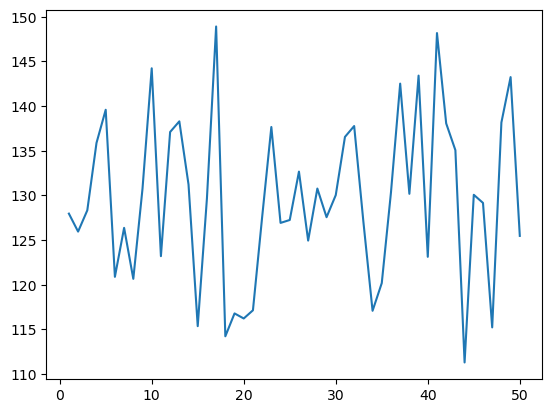

In [12]:
#plt.plot(np.array(valid_losses), 'r')
#plt.plot(np.array(train_losses), 'r')
#print(train_loss_values)
print(train_losses)
plt.plot(np.linspace(1, params['n_epochs'], params['n_epochs']).astype(int), train_losses)


In [13]:
# load the model that got the best validation accuracy
checkpoint = torch.load('checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.to(params["device"])
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, len_val)

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))

Test loss: 2.438
Test accuracy: 0.0% (0 of 10 right)

